In [2]:
import numpy as np
import pandas as pd 
from netgraph import Graph
import networkx as nx
from scipy import optimize
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import display, Markdown, Latex
import seaborn as sns 
import plotly.graph_objects as go
# import ecbcolors
import plotly.io as pio

# config
# ----------------------------------------
# ecb_colors= ecbcolors.colormaps.CM_CHART.colors
# pio.renderers.default = "notebook+pdf+vscode+jupyterlab"
# pio.templates["ECB"] = go.layout.Template(
#     layout=go.Layout(
#         colorway=["rgb"+str(tuple(c*255 for c in color)) for color in ecb_colors]
#     )
# )
# pio.templates.default = "plotly_white+ECB"
# plotly_config = {"staticPlot": True}
# pd.options.mode.chained_assignment = None
# pd.options.plotting.backend = "plotly"

# sns.set_context(context='notebook', font_scale=1.2)
# sns.set(rc={"figure.dpi": 100, 'savefig.dpi': 500})
# set_matplotlib_formats('retina')
# sns.set_style("ticks", {'axes.grid': True, 'grid.linestyle': ":",
#               "grid.alpha": 1, "grid.color": "#343434", "lines.linewidth": 2.5, "xtick.bottom" : True
# })

# sns.set_palette(ecb_colors)
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# An overview of the mathematics behind Eisenberg and Noe (2001)'s clearing vector

- Eisenberg and Noe (2001) [Management Science journaL](https://www.jstor.org/stable/pdf/2661572.pdf)
- Eisenberg and Noe (2001) [Discrete Mathematics and Computer Science
Conference on New Market Models](https://deliverypdf.ssrn.com/delivery.php?ID=916073065102102072109001015118086007063005031068030005011113077021103091105080116122080119007127070088042011124096094114076005089125080022091122120102004012119005122027011010008073025104&EXT=pdf&INDEX=TRUE) 

# General preliminary remarks 

- __Differential Equation__: A Differential Equation is an equation with a function and one or more of its derivatives:


$$
y + \frac{\partial y}{\partial x} = 0 \quad	 (1)
$$

with 

$$
y = f(x) \quad (2)
$$ 

This can also be seen as a derivative that is a function of its primitive function, that is: 

$$
\frac{\partial y}{\partial x} = - y = - f(x) \quad (3)
$$ 

- __Iterated function__: a function $X → X$ (that is, a function from some set X to itself) which is obtained by composing another function $f : X → X$ with itself a certain number of times. In this process, starting from some initial number, the result of applying a given function is fed again in the function as input, and this process is repeated.

$$
y_t = f(x) \text{ with } x= y_{t-1} \quad (4) 
$$

So this is clearly different from a DE, as this is simply taking an arbitrary function and iteratively feeding the output of the function as the input in the next iteration.

- __Fixed point__: a fixed point (sometimes shortened to fixpoint, also known as an invariant point) of a function is an element of the function's domain that is mapped to itself by the function. That is,

$$
x_0 \in Fix \iff f(x_0) = x_0 \quad (5)
$$ 

with $Fix$ the set of fixed points of function $f(x)$. 

For the function $f: \R^n \rightarrow  \R^n: f(x) \rightarrow x$, we have $ Fix \in \R^n $. 

- __Fixed points and iterated functions__: if $f(x)$ is a function that is being interated upon, and $x_0 \in Fix$, then we have: 

$$
f(f(...f(x=x_0)...))= f_n(x=x_0)= x_0 \text{ with } n \in \N \quad(6)
$$

That is, whenever the input of an iterated function, $f_n(x)$, is a fixed point, the output will be equal to the fixed point, irrespective of how much we keep iterating the function. The fixed point can be seen as a terminating condition when recursively computing the function $f$ with the fixed point $x_0$ being the convergence value. 

Note that not all functions have fixed points, e.g., $f(x)= x+c$ with $c\in\R_{\ne 0}$

- __Periodic point__: a periodic point of a function is a point which the system returns to after a certain number of function iterations or a certain amount of time. That is,

$$
x_0 \in Per \iff f_n(x=x_0)=x_0  \quad (7)
$$

with $Per$ the set of periodic points of function $f(x)$, and $n$ the period of the periodic point. The smallest positive integer n satisfying the above is called the prime period or least period of the point x.

Note that if $n=1$ we have $x_0 \in Fix$, that is a periodic point of period one is also a fixed point of $f(x)$. 


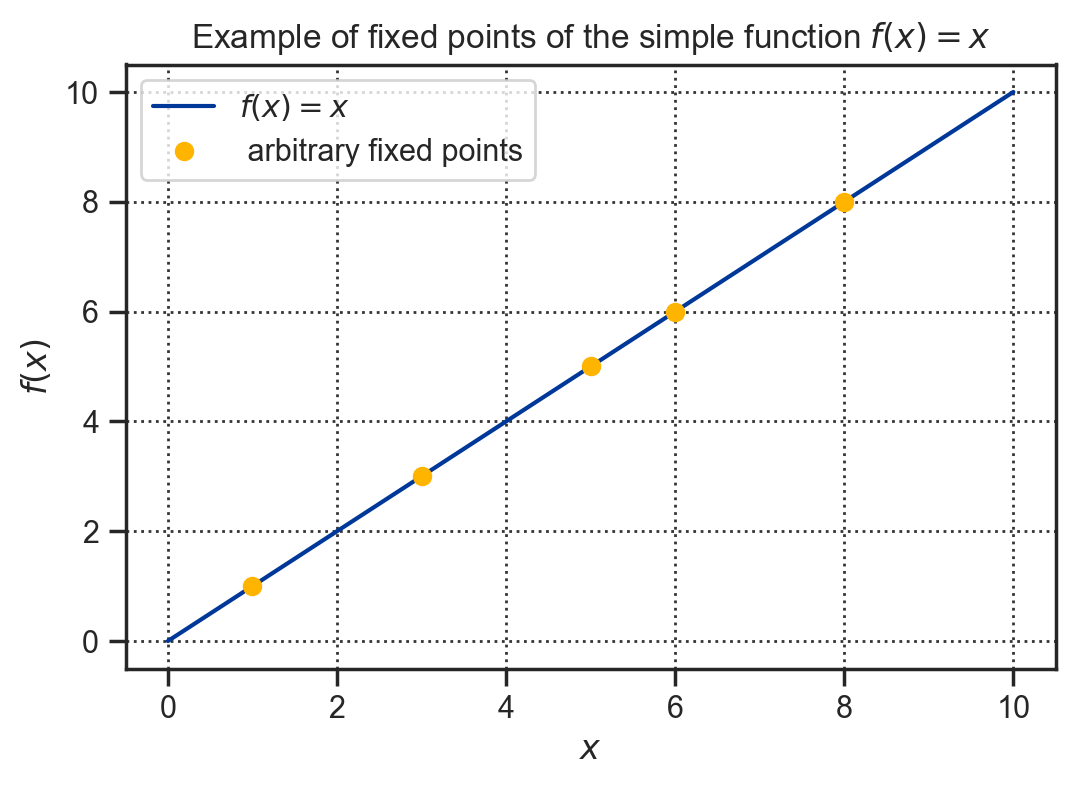

In [3]:
# Let's plot a function where the fixed points are equal to the domain of the function

x = np.linspace(0, 10, 11)
fixed_points= [1, 3, 5, 6, 8]
y= x
fig, ax= plt.subplots()
ax.plot(x,y, label="$f(x)=x$")
ax.plot(fixed_points, fixed_points, linestyle = 'None', marker= 'o', label= " arbitrary fixed points")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$");
ax.set_title("Example of fixed points of the simple function $f(x) = x$")
plt.show()

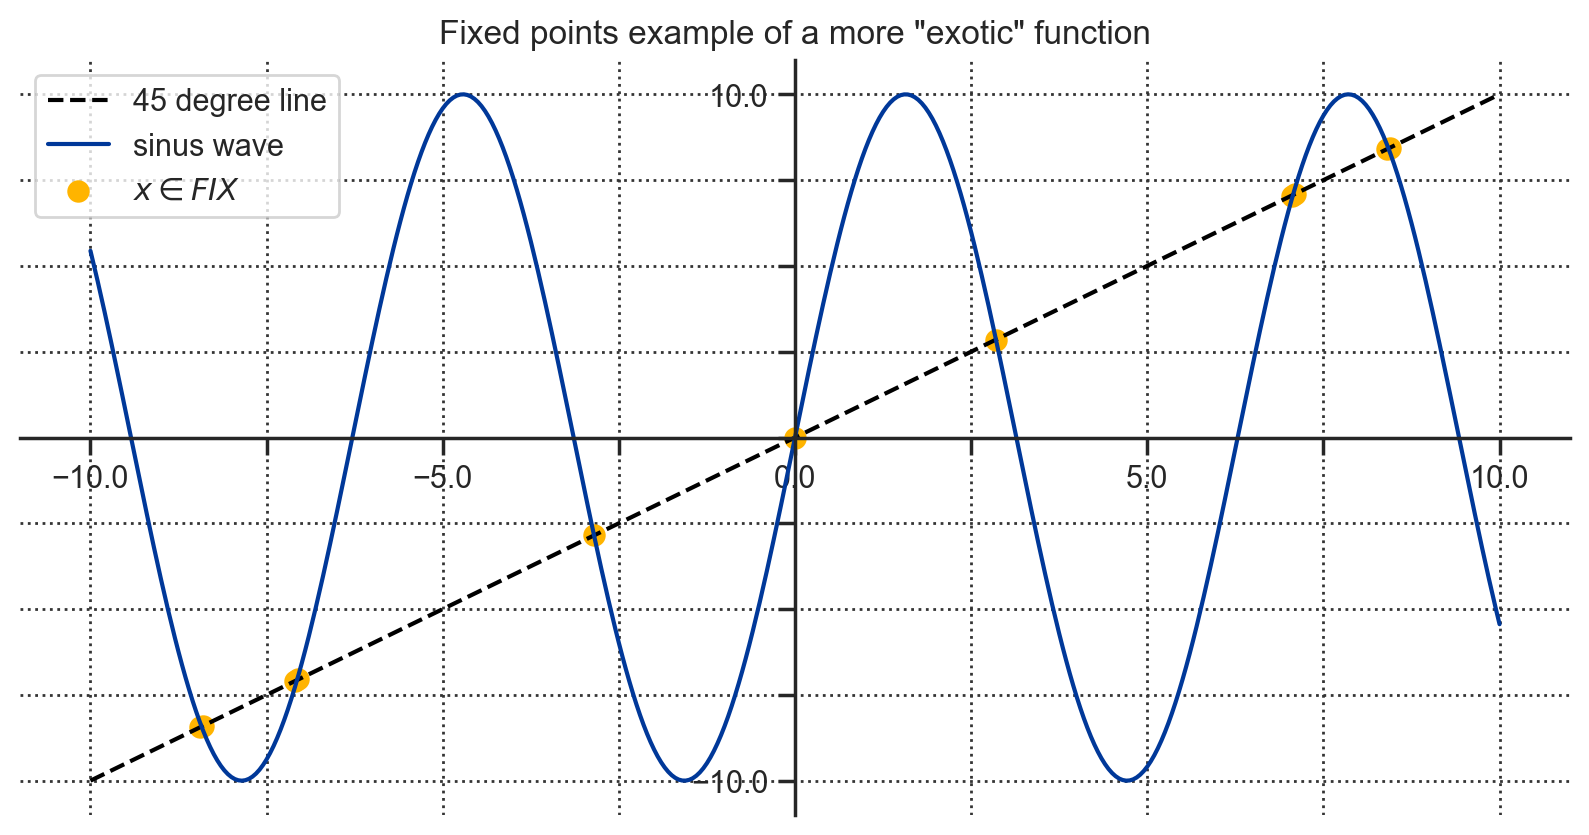

In [4]:
# Let's now plot a more "exotic" function with a specific set of fixed points

x = np.linspace(-10, 10, 401)
f = lambda x: 10*np.sin(x)
# Determine fixed points
FIX= []
for each_x in x: 
    if np.abs(f(each_x) - each_x) < 0.2:
        FIX.append(each_x)




fig, ax= plt.subplots(figsize= [10,5])
ax.plot(x, x, "--", color= "black", label= r"45 degree line")
ax.plot(x, f(x), label= "sinus wave")
ax.scatter(FIX, FIX, color= ecb_colors[1], alpha= 1, s= 50, label= r"$x \in FIX$")
#spine placement data centered
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)
for label in ax.get_yticklabels()[2:-2]:
    label.set_visible(False)
ax.set_title('Fixed points example of a more "exotic" function')
plt.legend();

Let's write a quick solver to help us find the fixed points of a function

In [5]:
def find_fix(f, x0, tol= 10**-16, maxiter= 100, args= ()):
    """Solver to find the fixed point of a function f"""
    

    x0 = np.asarray(x0)
    x = []
    i, err = 0, tol + 1
    # Main engine
    while err > tol and i <= maxiter:
        x0 = f(x0, *args)
        err = np.abs(f(x0, *args) - x0).sum()
        i += 1
        x.append(x0)
    return x

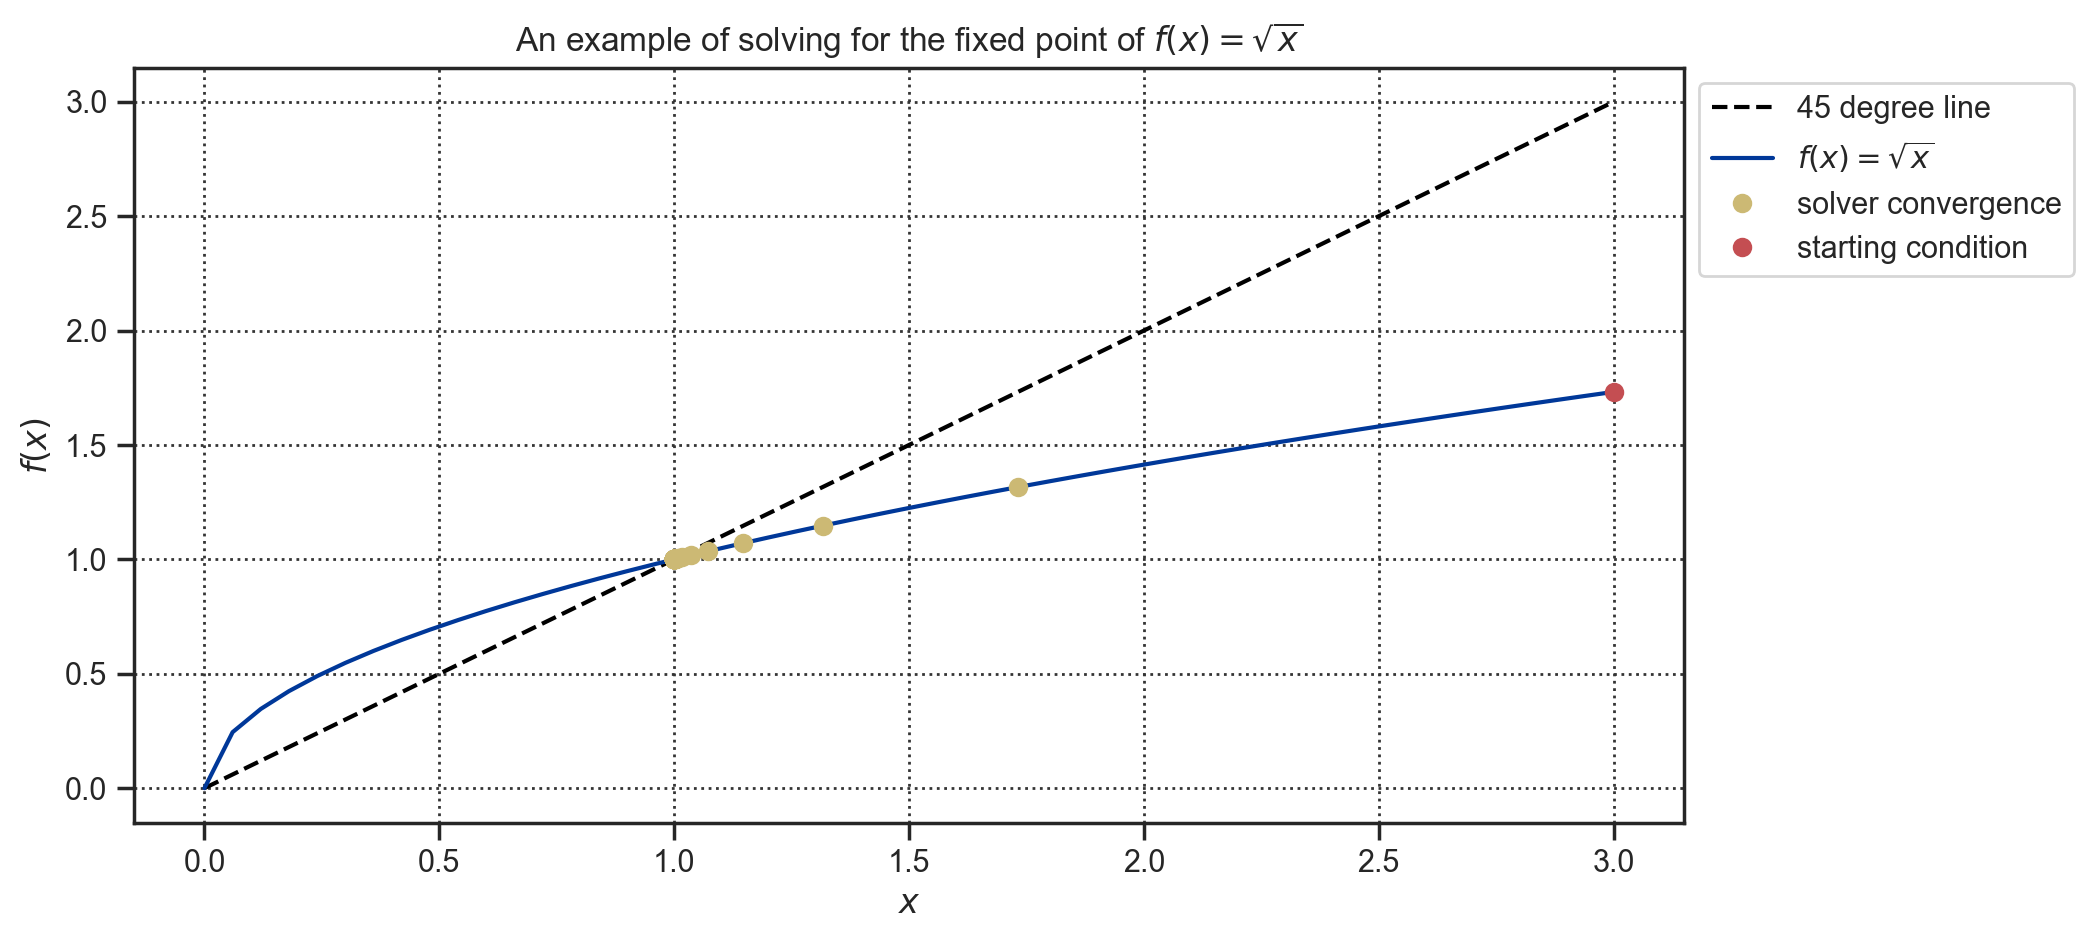

In [6]:
# Test out solver
x = np.linspace(0, 3, 51)
f = lambda x: x**(1/2)
x0= 3
FIX= find_fix(f, x0)

fig, ax= plt.subplots(figsize= [10,5])
ax.plot(x, x, "--", color= "black", label= r"45 degree line")
ax.plot(x, f(x), label= r"$f(x)=\sqrt{x}$")
#ax.scatter(FIX, FIX, color= ecb_colors[1], alpha= 1, s= 50, label= r"$x \in FIX$")
ax.plot(FIX, f(np.array(FIX)), "yo", label= "solver convergence")
ax.plot(x0, f(np.array(x0)), "ro", label= "starting condition")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")
ax.set_title(r"An example of solving for the fixed point of $f(x)=\sqrt{x}$")
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fancybox=True,);

Let's compare the speed of our iterative solver with the inbuild version of `SciPy` that utilizes the [Steffensen’s Method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fixed_point.html)

It seems that our function is faster than the `SciPy` version, but this most likely reverses for more complicated functions (which we'll try down below).

In [7]:
%%timeit
FIX= optimize.fixed_point(f, x0= [x0])
assert FIX[0] < 1.000000000000001 and FIX[0] > 0.999999999999999999

783 µs ± 104 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%%timeit
FIX = find_fix(f, x0)
assert FIX[-1] < 1.000000000000001 and FIX[-1] > 0.999999999

365 µs ± 26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Note that the we are allowed to have a function $f: R^n \rightarrow R^n: f(x) \rightarrow x$ , that is the same logic that we discussed up until now also makes sense for functions that take as I/O a vector instead of a scalar.

In [9]:
# our function in R_2
# Starting vector 
x0= [10, 12]
# Solve 
FIX= optimize.fixed_point(f, x0)
Latex(fr"The fixed point vector of $f(x) = \sum_X (x - \bar{{x}})^2$ is: ${FIX}$ with $x \in \R^2$")

<IPython.core.display.Latex object>

Lastly, note how the function $f(x) = \sqrt{x}$ has two fixed points, $\{0, 1\} \in FIX$, but the optimizer converges to a particular fixed point (the _attractor_) independent of which initial point we start from within the domain $R^+$. For $R_0^+$ we can converge to $0$ in case the initial point is another fixed point, i.e. $x_0 = 0$. 

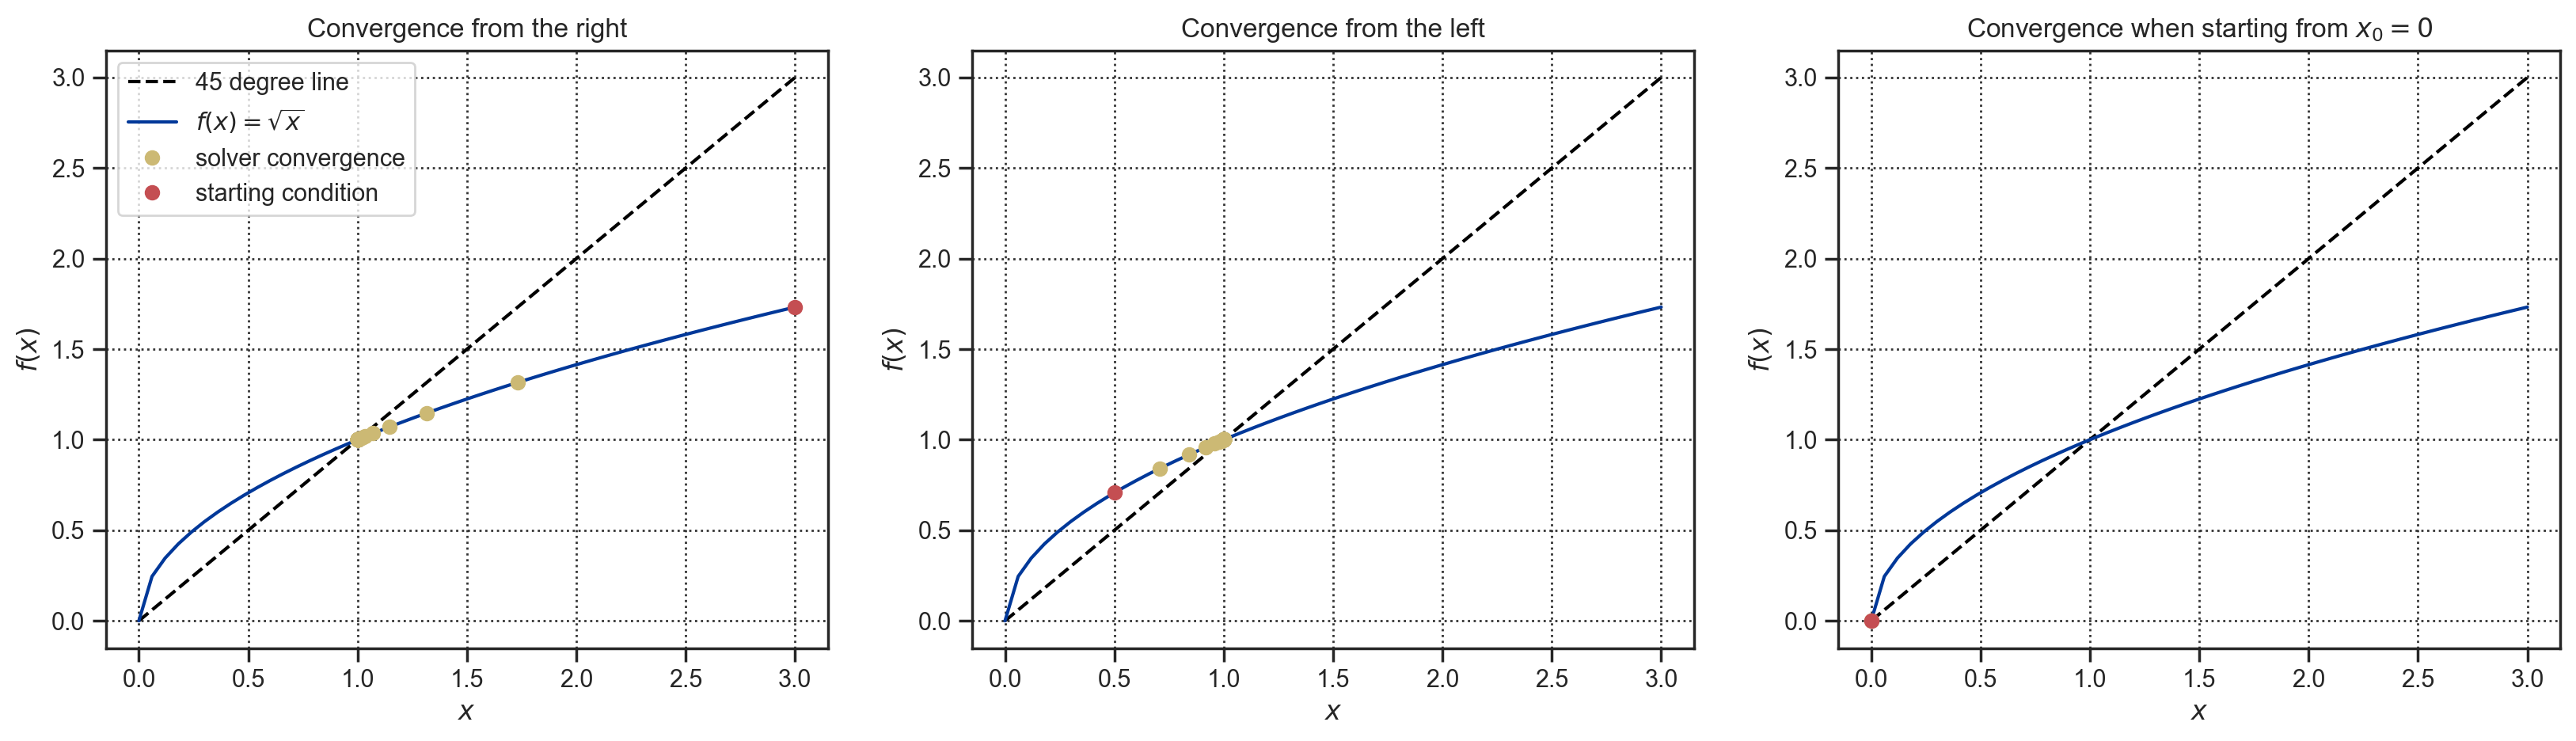

In [10]:
fig, ax= plt.subplots(1,3, figsize= [20,5])



x = np.linspace(0, 3, 51)
f = lambda x: x**(1/2)
x0= 3
FIX= find_fix(f, x0)
ax[0].plot(x, x, "--", color= "black", label= r"45 degree line")
ax[0].plot(x, f(x), label= r"$f(x)=\sqrt{x}$")
ax[0].plot(FIX, f(np.array(FIX)), "yo", label= "solver convergence")
ax[0].plot(x0, f(np.array(x0)), "ro", label= "starting condition")
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$f(x)$")
ax[0].set_title("Convergence from the right")


x = np.linspace(0, 3, 51)
f = lambda x: x**(1/2)
x0= .5
FIX= find_fix(f, x0)
ax[1].plot(x, x, "--", color= "black", label= r"45 degree line")
ax[1].plot(x, f(x), label= r"$f(x)=\sqrt{x}$")
ax[1].plot(FIX, f(np.array(FIX)), "yo", label= "solver convergence")
ax[1].plot(x0, f(np.array(x0)), "ro", label= "starting condition")
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$f(x)$")
ax[1].set_title("Convergence from the left")



x = np.linspace(0, 3, 51)
f = lambda x: x**(1/2)
x0= 0
FIX= find_fix(f, x0)
ax[2].plot(x, x, "--", color= "black", label= r"45 degree line")
ax[2].plot(x, f(x), label= r"$f(x)=\sqrt{x}$")
ax[2].plot(FIX, f(np.array(FIX)), "yo", label= "solver convergence")
ax[2].plot(x0, f(np.array(x0)), "ro", label= "starting condition")
ax[2].set_xlabel(r"$x$")
ax[2].set_ylabel(r"$f(x)$")
ax[2].set_title("Convergence when starting from $x_0=0$")



ax[0].legend();

# Eisenberg and Noe (2001) clearing vector $P$

Next we briefly discuss the clearing vector $P$ of Eisenberg and Noe (2001). 

Consider the following interbanking system $(N, \Pi, \bar{p}, e)$ with: 

- $N$: number of banks in the system
- $\Pi$: the relative obligations matrix with $\Pi_{i,j}$ the relative obligation that bank $i$ has towards bank $j$. This is relative to the total amounts of obligations that bank $i$ has. 
- $\bar{p}$: the total obligation vector in nominal amounts. $\bar{p_i}$ represents the total obligations of bank $i$ to the system. 
- $e$: the operating cash flow/equity vector. $e_i$ represents the  total operating cash flow of bank $i$. 


We want to solve the __problem of "clearing" the market__ at any moment in time. That is considering the system $(N, \Pi, \bar{p}, e)$, how much does each bank $i$ has to pay up to the other banks? I.e. what should the __payment vector__ $\bm{p^*}$ be? This taking into account the following __three conditions__:

- __proportionallity__: If a default occurs, each creditor in the system related to the defaulting bank gets paid by the defaulting entity in proportion to the size of their respective nominal claims on the defaulting bank. 
- __limited liability__: $\forall i \in N, p^*_i \leq e_i + \sum_{j=1}^N \Pi_{ij}^Tp_j^*$. That is bank $i$ cannot pay more than what it has. 
- __absolute priority__: $\forall i \in N, p^*_i \in \{\bar{p}_i, e_i + \sum_{j=1}^N \Pi_{ij}^Tp_j^*\}$. That is bank $i$ either pays its obligations in full, or it pays all of it's creditors proportionally with all of its operating cash flow. No situation is possible, where the equity holders of $i$ are able to retain cash flows when obligations are not paid out in full. 

- Note that the _limited liability_ and _abolute priority_ conditions imply: $p^* \in [0,\bar{p}]$

Thus we have that, 

$$
p_i^* = e_i + \sum_{j=1}^N \Pi_{ij}^Tp_j^* \wedge \bar{p}_i \quad (8)
$$

with 
$$
x \wedge y := min(x,y)
$$

The first term of (8) represents "the cash flow that the banks have", whereas the second term represents "what the banks need to pay out". We can thus reformulate this problem as a fixed point problem of a certain mapping $\Phi(p, .): [0,\bar{p}] \rightarrow [0,\bar{p}]$, with $\Phi( p, .)$ representing the total funds that will be distributed when banks receive inflows determined by $p$ from their debt claims from other banks. The mapping can concretely be defined as: 

$$
\Phi(p; \Pi, e, \bar{p}) \equiv (e + \Pi^T p) \wedge \bar{p} \quad (9)
$$

with 
$$
x \wedge y := (min(x_1, y_1), ..., min(x_n, y_n))
$$


Eisenberg & Noe (2001) show extensively that under a mild additional condition of _regularity_ (see below), that a unique clearing vector can be attributed to regular systems, and that this is the fixed-point of (9). Iterating over this mapping until it's fixed point is reached, yields the clearing vector $p^*$ that maximizes the payment flows to banks. 

Note that, in contrast to our earlier examples above, Eisenberg and Noe show that each system has a _unique_ fixed point. Thus we don't need to be concerned with being stuck at a potential "wrong" fixed point, or trying to find all of the possible fixed points. It also doesn't matter whether we start the iteration with the lowerbound, $p_0=0$ or the upper bound $p_0=\bar{p}$. Normally this would yield respectively the lowest and highest fixed point of the system, which in an Eisenberg and Noe system are simply the same (this is also how they proof the uniqueness of the clearing vector).


TODO: regularity constraint

## The regularity condition

To ensure that an Eisenberg and Noe system has a unique clearance vector $p^*$ we need to make sure that there is: 

 (i) positive equity value in the system 
  
 (ii) that this income can travel to other nodes in well behaved manner

Otherwise we end up in situations where we have an infinite amounts of clearing vectors $p^*$ that satisfy the three main Eisenberg and Noe conditions (see below for a concrete example). 

To ensure that the above two conditions satisfy our system we first answer the question of how far an inital (random) default shock can propagate into the system. We know that there is a natural upperbound to this question depending on the exact graph configuration. That is, a shock can only propagate through a directed path from where it originated. In case we have a node $A$ that is going into default, and node $K$ is not linked to $A$ through a directed path, then $K$ will not witness any impact of the potential cascading effect initialized by $A$. The below graph shows such an example. We can formalize this notion as:

$$ 
O(i) = \{j \in N | \text{if the path (i,j) exists} \} \quad (10)
$$

with $O(i)$ being defined as the __risk orbit__ of node $i$, that is all of the nodes that are directly linked to $i$.

Next we define the notion of a surplus set: 

$$
\forall (i,j) \in S\times S^c: \Pi_{ij} = 0 \text{ and } \sum_{i\in S}e_i > 0 \Leftrightarrow S \subset N \text{ is a surplus set} \quad (11)
$$

That is the set of nodes $S$ is a surplus set if the nodes within the set do not have any obligations towards nodes outside of this set and that there is some positive capital within this set. 

Combining (10) and (11) and taking into account that a risk orbit is a closed system, it is relatively straightforward to see that a risk orbit $O(i)$ is a surplus set under $p^*$ if one of the nodes within the orbit has positive equity. 

If every node $i$ in the system has an associated risk orbit $O(i)$ that is a surplus set, then the __system is called regular__ as it ensures the existence of a unique clearing vector by avoiding the situation laid out above. 

An example follows down below. 

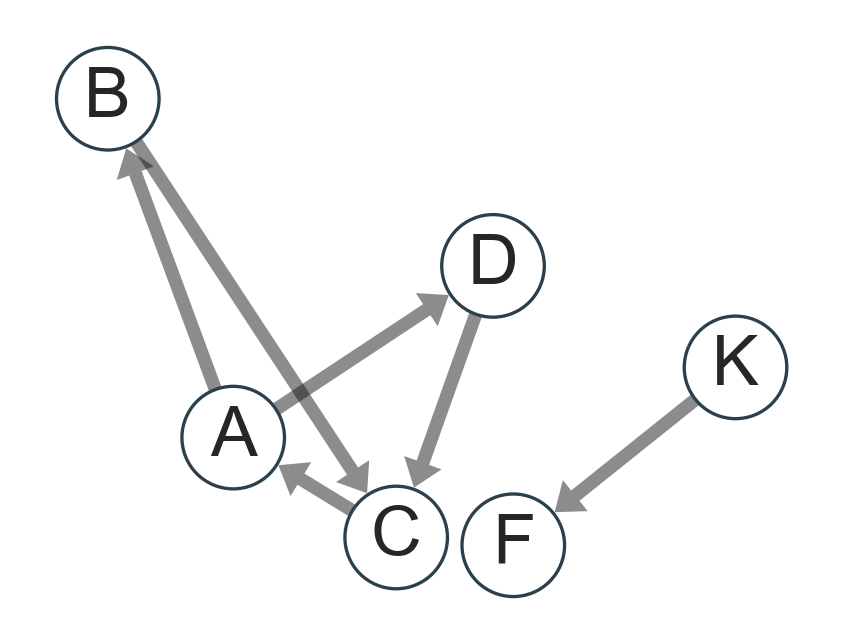

In [11]:
G = nx.DiGraph()
G.add_weighted_edges_from([("A", "B", 1), ("B", "C", 1), ("C", "A", 1), ("A", "D", 1), ("D", "C", 1), ("K", "F", 1)])

fig, ax1 = plt.subplots(1, 1)


g = Graph(G, edge_width= 2, arrows= True, node_size= 8,
node_labels= True,  ax= ax1, )
plt.show()

To clarify, imagine the following system $(N, \Pi, \bar{p}, e)$: 

- $N= 3$
- $\Pi =$ $\begin{bmatrix} 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \end{bmatrix}$
- $\bar{p} =$ $\begin{bmatrix} 1 & 1 & 1  \end{bmatrix}$
- $e =$ $\begin{bmatrix} 0 & 0 & 0  \end{bmatrix}$

with the associated graph on the left side of the below figure: 

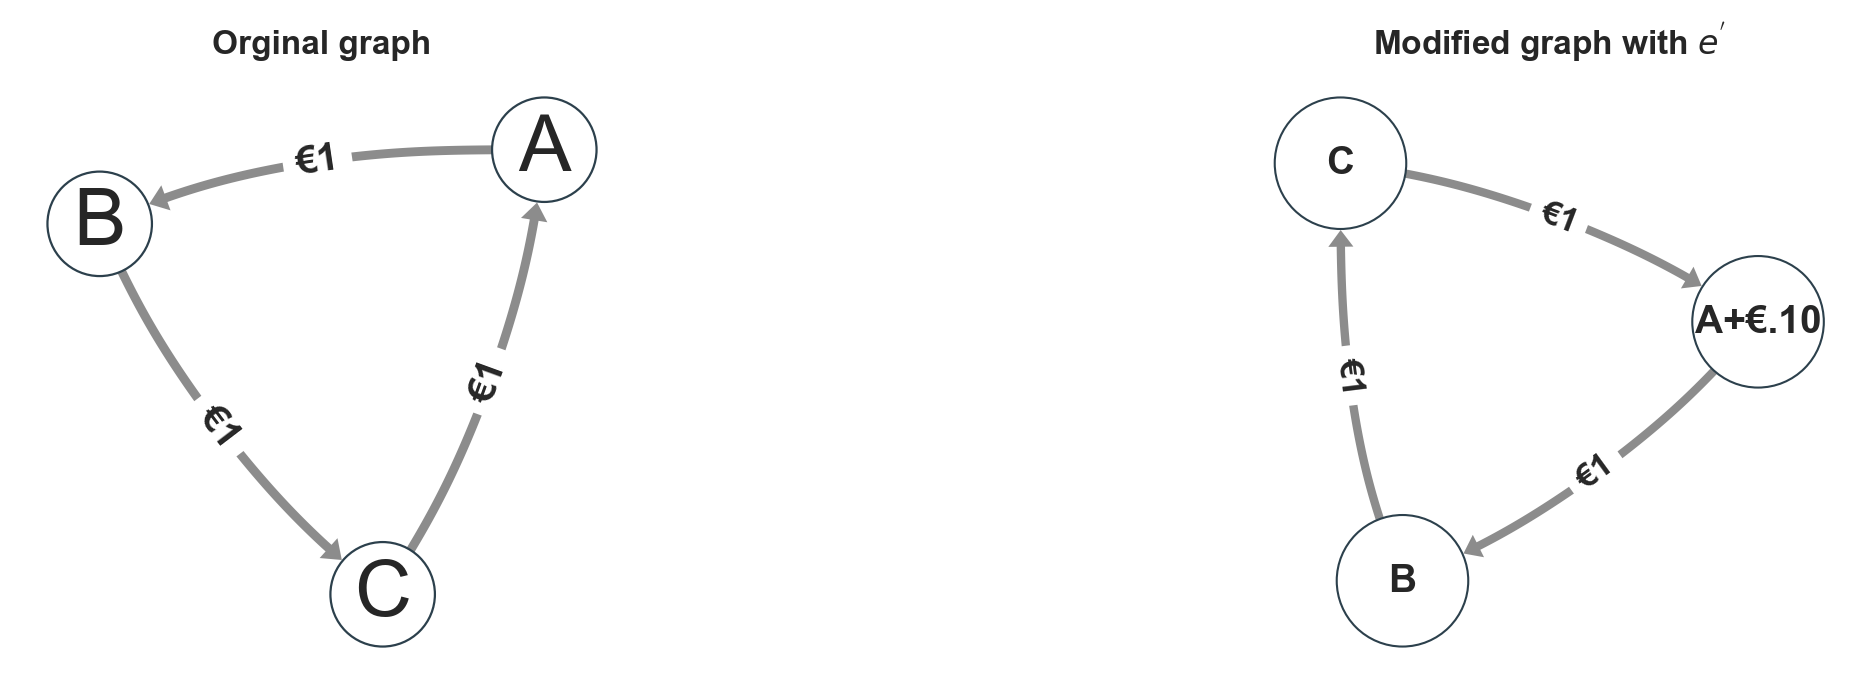

In [12]:
G = nx.DiGraph()
G.add_weighted_edges_from([("A", "B", 1), ("B", "C", 1), ("C", "A", 1)])


fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=None, hspace=None)

node_positions = {
    "A" : (0.5, 0.5),
    "B" : (0, 0),
    "C" : (1, 0)
}

g = Graph(G, edge_width= 2, arrows= True, node_size= 12, edge_layout= "curved",
node_labels= True, edge_labels = {k:"€1" for k in [("A", "B"), ("B", "C"), ("C", "A")]}, 
edge_label_fontdict=dict(fontweight='bold', size= 14), ax= ax1, )
ax1.set_title("Orginal graph", fontweight= "bold")
h = Graph(G, edge_width= 2, node_size= 16,    arrows= True,
node_labels = {"A": "A+€.10", "B": "B", "C": "C"}, edge_labels = {k:"€1" for k in [("A", "B"), ("B", "C"), ("C", "A")]},
edge_label_fontdict=dict(fontweight='bold'), ax= ax2, node_label_fontdict=dict(fontweight='bold', size=14), edge_layout= "curved")
ax2.set_title(r"Modified graph with $e^{'}$", fontweight= "bold")
plt.show()

Note that we have $O(i) = O =  \{A, B, C\} \quad \forall i$, and that the set $O$ is __not__ a surplus set, thus the regularity constrain is not satistified. 


In this case, the solution to the optimal clearance vector yields:

$$
p^* = \begin{bmatrix} a & a & a  \end{bmatrix}
\text{with } a \in [0, \bar{p_i}=1]
$$

In other words, we have an infinite number of potential vectors that would yield the same economic result when trying to clear the market. E.g. when $a=0.5$ we have that each node should pay back 50 cents to each directed neighbor and would simultaneously receive 50 cents from the other neighbor. When we change $a$ to, let's say $0.80$, the same behavior is observed with the resulting economic value remaining the same for each node. 

Now, let us inject some capital into the system, that is consider the same system but now with the equity vector being: 

$$ 
e^{'} = \begin{bmatrix} 0.1 & 0 & 0  \end{bmatrix} 
$$

as represented on the right side of the above figure. We see now that almost all of the previously obtained clearance vectors are void as they nullify the absolute priority condition imposed on node $A$. E.g. if we take $a=0.5$ again, then we see now that $A$ is holding capital without paying of all of its debt, nullyfing its absolute priority condition. The only remaining valid clearance vector is: 

$$
p^* = \begin{bmatrix} 1 & 1 & 1  \end{bmatrix}
$$

which is now also a __unique__ solution of the system. In this case, $O$ is a surplus set and $A$ satisfies all of its conditions by fully repaying its debt obligations. 

## Let's create an exemplary Eisenberg and Noe system and try to find $p^*$


#### Example of pg. 19 of Eisenberg & Noe paper

In [13]:
# Create an Eisenberg and Noe system 

N = 4
e = np.array([1/5, 3/10, 1/10, 2/5]).reshape(-1,1)
p_bar = np.array([1, 6/5, 1/5, 4/5]).reshape(-1,1)
pi = np.array([
    [0, 15/16, 1/16, 0],
    [0,0,15/16,1/16],
    [1/16,0,0,15/16],
    [0,3/4,1/4,0]

])
cols = [chr(i) for i in range(ord('A'), ord('A')+N)]

display(Latex(r"$\Pi$ relative obligation matrix:"))
display(pd.DataFrame(pi,columns= cols, index =cols))
display(Latex("$e$:"))
display(pd.DataFrame(e.T,columns= cols))
display(Latex(r"$\bar{p}$:"))
display(pd.DataFrame(p_bar.T,columns= cols))

<IPython.core.display.Latex object>

,A,B,C,D
A,0.000,0.938,0.062,0.000
B,0.000,0.000,0.938,0.062
C,0.062,0.000,0.000,0.938
D,0.000,0.750,0.250,0.000


<IPython.core.display.Latex object>

,A,B,C,D
0,0.200,0.300,0.100,0.400


<IPython.core.display.Latex object>

,A,B,C,D
0,1.000,1.200,0.200,0.800


Next, we define the mapping $\Phi(p,.)$

In [14]:
# Phi mapping
phi = lambda p, p_bar, e, pi: np.minimum( e + pi.T @ p, p_bar)
# Test out function
p = p_bar
display(Latex(r"$\Phi(p=\bar{p},.)$ example output:"))
display(pd.DataFrame(phi(p, p_bar, e, pi).T,columns= cols))


<IPython.core.display.Latex object>

,A,B,C,D
0,0.213,1.200,0.200,0.663


Now, we try to solve for the fixed point $p^*$

In [15]:
p_star= optimize.fixed_point(phi, x0= p_bar, args=(p_bar, e, pi), xtol= 10**-16)
p_star= find_fix(phi, x0= p_bar, args=(p_bar, e, pi), tol= 0)

In [16]:
display(Latex(r"$\Phi(p= p^*,.)$ optimum:"))
display(pd.DataFrame(p_star[-1], index= cols))

<IPython.core.display.Latex object>

,0
A,0.213
B,0.986
C,0.200
D,0.649


#### Example of pg. 8 of Eisenberg & Noe paper

In [17]:
# Create an Eisenberg and Noe system 

N = 4
e = np.array([0.2, 0.3, 0.1, 0.4]).reshape(-1,1)
p_bar = np.array([1,1.2,0.2,0.8]).reshape(-1,1)
pi = np.array([
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, .75, .25, 0]

])

display(Latex(r"$\Pi$ relative obligation matrix:"))
display(pd.DataFrame(pi,columns= cols, index=cols))
display(Latex("$e$:"))
display(pd.DataFrame(e.T,columns= cols))
display(Latex(r"$\bar{p}$:"))
display(pd.DataFrame(p_bar.T,columns= cols))

<IPython.core.display.Latex object>

,A,B,C,D
A,0.000,1.000,0.000,0.000
B,0.000,0.000,1.000,0.000
C,0.000,0.000,0.000,1.000
D,0.000,0.750,0.250,0.000


<IPython.core.display.Latex object>

,A,B,C,D
0,0.200,0.300,0.100,0.400


<IPython.core.display.Latex object>

,A,B,C,D
0,1.000,1.200,0.200,0.800


Next, we define the mapping $\Phi(p,.)$

In [18]:
# Phi mapping
phi = lambda p, p_bar, e, pi: np.minimum( e + pi.T @ p, p_bar)
# Test out function
p = p_bar
display(Latex(r"$\Phi(p=\bar{p},.)$ example output:"))
display(pd.DataFrame(phi(p, p_bar, e, pi).T,columns= cols))


<IPython.core.display.Latex object>

,A,B,C,D
0,0.200,1.200,0.200,0.600


Now, we try to solve for the fixed point $p^*$

In [19]:
p_star= optimize.fixed_point(phi, x0= p_bar, args=(p_bar, e, pi), xtol= 10**-16)
p_star= find_fix(phi, x0= p_bar, args=(p_bar, e, pi), tol= 0)

In [20]:
display(Latex(r"$\Phi(p= p^*,.)$ optimum:"))
display(pd.DataFrame(p_star[-1],index= cols))

<IPython.core.display.Latex object>

,0
A,0.200
B,0.950
C,0.200
D,0.600


## The fictitious default algorithm 

Eisenberg and Noe go on to show that there exists an alternative way of solving the fixed point problem for $\Phi(p, .)$, which they dub the _fictitious default algorithm_. The algorithm has two main advantages over the traditional iteration method: 

1. Efficient optimization with convergence in maximum $N$ iterations.
2. Economic interpretation of the algorithm yielding a systemic risk partitioning. The first nodes that go into default are the insolvent ones, the second set of nodes going into default are the ones that are quite fragile as they go into default as soon as the insolvent nodes go into default. More specific, m-th nodes going into default are of m-th order failiure with $m \leq N$. 


The procedure is iterative and starts off with the initial clearing vector, $p_1 = \bar{p}$. Then we analyze which banks go into default in this case. If no defaults occur, the algorithm ends and $p_1 = p^*$. Else, create a new payment vector $p_2$ assuming that only the defaulting nodes from the previous iteration are in default. More specific, solve the system of equations that equate inflows with outflows with fixed payments of non-defaulting nodes set to $\bar{p}$: 

$$
Payments = Inflows
$$

Which equates to the following two systems of linear equations, 


\begin{align*} 
&p(i \in D) = e(i \in D) + \Pi^T(i \in D, j \in N)p(i \in D) \quad (10.A) \\
&p(i \not\in D)= \bar{p}(i \not\in D) \quad \quad  \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad  (10.B)
\end{align*}


We merge these two systems into one general system of linear equations so we can work towards getting a system in the form of $Ap= b$ which is easier to solve: 

$$
p = e_s + \pi_s^{T}p + \bar{p}_s \quad (11)
$$

with, 

- $e_s$ being the equity/cash flow vector, but with $e(i \not\in D) = 0$. 
- $\pi_s$ being the relative liability matrix, but with $\pi(i \not\in D, j \in N) = 0$.
- $\bar{p}_s$ being the total liabilities vector, but with $\bar{p} (i \in D) = 0$.

and $D$ the set of defaulting nodes. 


(11) is basically saying that all non-defaulting nodes, $i \not\in D$, are repaying all of their debt claims, $\bar{p}(i \not\in D)$. In contrast, the defaulting banks, $i \in D$  aren't able to clear all their debt claims and instead are simply abiding the _absolute priority_ condition by paying out their total cash flows. 

Next we solve for $p$, 


$$
p - \pi_s^{T}p = e_s + \bar{p}_s 
$$

Extracting $p$ yields then, 

$$
(\textbf{1} - \pi_s^{T})p = e_s + \bar{p}_s  \quad (12)
$$

with $\textbf{1}$ the identity matrix with dimension $N$. (12) is a linear system of the form $Ap=b$ which we can efficiently solve for $p$. 

In [21]:
def fictitious_D(pi, e, p_bar):
    """fictitious default algorithm of Eisenberg and Noe (2001)"""


    ## Initialize algorithm
    # --------------------------
    N = len(e)
    # We start from the assumption that all nodes are able to pay their debt
    p = p_bar
    # algorithm runs until equilibrium is found
    in_equilibrium = False
    

    ## Start algorithm 
    # ------------------------
    i = 0
    while not in_equilibrium and i <= N:

        # Step 1: Track potential defaults
        D = (e + pi.T@p < p_bar).reshape(-1)
        ND = (e + pi.T@p >= p_bar).reshape(-1)

        # Step 2: Solve system Ax=b with defaulting banks paying 
        # e + pi.T @ p and non-defaulting banks still paying p_bar
        
        # Copy information over
        pi_modi = pi.copy()
        e_modi = e.copy()
        p_bar_modi= p_bar.copy()

        # Non-defaulting banks pay p_bar while defaulting pay e + pi.T @ p
        pi_modi.T[ND, :] = 0
        e_modi[ND]= 0
        p_bar_modi[D]= 0
        
        # Set up system Ap=b and solve for p
        A = np.eye(N) - pi_modi.T
        b = e_modi + p_bar_modi
        p = np.linalg.solve(A, b)

        # Step 3: Check if equilibrium is reached, 
        # or whether new banks are going into default now that the current set of 
        # defaulted banks are only paying e + pi.T @ p instead of p_bar
        D_new = (e + pi.T@p < p_bar).reshape(-1)
        in_equilibrium = np.array_equal(D, D_new)
        
        i+=1

    print(f"Fictitious default algorithm converged in {i} steps!")
    return p

In [22]:
# Fictitious default algorithm 
N = 4
e = np.array([1/5, 3/10, 1/10, 2/5]).reshape(-1,1)
p_bar = np.array([1, 6/5, 1/5, 4/5]).reshape(-1,1)
pi = np.array([
    [0, 15/16, 1/16, 0],
    [0,0,15/16,1/16],
    [1/16,0,0,15/16],
    [0,3/4,1/4,0]

])

p_star= fictitious_D(pi, e, p_bar)
display(Latex(r"$\Phi(p= p^*,.)$ optimum:"))
display(pd.DataFrame(p_star))

Fictitious default algorithm converged in 2 steps!


<IPython.core.display.Latex object>

,0
0,0.213
1,0.986
2,0.200
3,0.649


## The optimization problem

Eisenberg & Noe (2001) also show that the problem of finding $p^*$ can be reformulated as a typical optimization problem,
where one tries to maximize the payments in the system constrained to the limited liability condition. 

We have, 

$$
\max_{p\in[0,\bar{p}]} f(p) \\ 
\textrm{s.t.} \quad p \leq e + \Pi^T \cdot p  \quad \quad \quad \quad  (13)
$$

with, $f(p)$ being a linear, strictly increasing function. In this case any solution for (13), irrespective of the exact form of $f(p)$ will be an optimal clearing vector for the system $(\Pi, \bar{p}, e)$.

Note, that we can once again rewrite the constraints of $(13)$ in the form $Ap=b$, 
$$
\max_{p\in[0,\bar{p}]} f(p) \\ 
\textrm{s.t.} \quad (\textbf{1} - \Pi^T)\cdot p \leq e 
$$


Because clearing vectors are determined entirely by the limited liability and absolute priority conditions, it follows that these two conditions always produce pay-off vectors that maximize the total extraction of payments from the nodes in the financial system. Because
 the clearing vector is unique in any regular financial
 system, the result also implies that in regular financial systems, all decision makers who prefer more to
 less will agree that the clearing vector maximizes their
 objectives. Thus, for example, whether one attempts to
 maximize cents on the dollar paid or total payments,
 or payments weighted by a biased weighting scheme
 that favors some nodes over others, the end result
 will be the same: the selection of the clearing vector.


Let's implement a solver for $(13)$

In [23]:
from scipy.optimize import linprog


def lin_prog_optimization(pi, e, p_bar):
    """Solve Eisenberg and Noe (2001) as a linear programming problem"""

    # Number of banks
    N = len(e)

    ## linprog of SciPy takes problems in the form of: min f(x) s.t. g(x) <= c
    # ------------------------------------------------------------------------

    # objective function coefficients: we simply choose weights to be equal to one for all banks
    # we multiply by (-1) to get a minimization problem
    obj = np.ones(N)*(-1)

    # contraint matrix A
    lhs_constraints = np.eye(N) - pi.T
    rhs_constrints = e

    # bounds: p \in [0, p_bar]
    bnd = [(0, p[0]) for p in p_bar]

    # Optimize problem
    opt = linprog(c=obj, A_ub=lhs_constraints, b_ub=rhs_constrints,
                bounds=bnd, method="revised simplex")

    return opt

In [24]:
# Our example system 
N = 4
e = np.array([1/5, 3/10, 1/10, 2/5]).reshape(-1,1)
p_bar = np.array([1, 6/5, 1/5, 4/5]).reshape(-1,1)
pi = np.array([
    [0, 15/16, 1/16, 0],
    [0,0,15/16,1/16],
    [1/16,0,0,15/16],
    [0,3/4,1/4,0]

])

# solve als lin prog problem 
results = lin_prog_optimization(pi, e, p_bar)

p_star= results.x
display(Latex(r"$\Phi(p= p^*,.)$ optimum:"))
display(pd.DataFrame(p_star))


<IPython.core.display.Latex object>

,0
0,0.212
1,0.986
2,0.200
3,0.649


# Montagna and Kok (2016) agent-based model 

Now that we have a decent grasp of what a clearing vector entails on how to find one, we can move ahead and construct a shock propagation model. The model is based on the one introduced in [Montagna & Kok (2016)](https://www.ecb.europa.eu/pub/pdf/scpwps/ecbwp1944.en.pdf?d651ce4dbb03490006782ff86e6c848e), and makes use of a multilayered network to construct an agent-based model of banks. 

A interbank system is defined by the triplet $\Omega = (V, \bm{W}, L)$

with 

- $V$ the nodes in the system
- $\bm{W} = (W^1, ..., W^L) \text{ with } W^l \in R^{n\times n}$ a set of genreally directed and weighted adjacency matrices linked to the system. Each matrix $W^l$ represents a distinct layer within the multilayer network
- $L$ is simply the set of labels attached to the different layers, with the same cardinality as $\bm{W}$


Each node $i$ is characterized by its balance sheet:

|               **Assets** 	|                **Liabilities** 	|
|-------------------------:	|-------------------------------:	|
| $c_i$: cash              	| $d_i$: deposits                	|
| $e_i$: securities        	| $eq_i$: equity                         	|
| $l_i^l$: long-term loans  	| $b_i^l$: long-term borrowings   	|
| $l_i^s$: short-term loans 	| $b_i^s$: short-term borrowings$ 	|
| $o_i^a$: other assets     	| $o_i^l$: other liabilities           	|


Using both the network information as the balance sheet data we can carefully construct a micro-structural shock propagation model. 

The first layer of the network represents the __long-term interbank credit market__ where banks borrow and lend on the long term to each other, the market is embedded with __counterparty risk__. That is, when a debtor isn't able to repay its obligations then its creditors will need to book the given loans as losses. The second layer represent the __short-term interbank credit/liquidity market__ where banks use short-term debt to finance their balance sheet activities, the market is embedded with __funding risk__. That is, when a creditor starts hoarding liquidity its debtors will have trouble to further fund their balance sheet activities. The last layer represents the __external securities market__ that are __marked-to-market__ with nodes in the system having potential overlapping portfolio's consisting of the same securities, the market is embedded with __market risk__. That is, a node selling selling a large portion of its portfolio might decrease the price of securities resulting in the detoriation of the balance sheet of other nodes holding the same securities leading to a potential __fire sales__ spiral.

To model the __external securities market__, we need to know (i) the prices of the securities, (ii) the amount that each node $i$ is holding of security $\mu$ and (iii) the way that prices change through time (which is __endogenously__ determined):

- The initial price of security $\mu$ is $p_{\mu}^0 \quad \forall \mu \in {1, ..., M}$ with $M$ the number of available securities. 
- The notional amount that node $i$ has of security $\mu$ is $s_{\mu}^i$
- The total market value of the external securities portfolio of node $i$ is then, 
$$
e_i = \sum_{\mu=0}^M p_{\mu}s_{\mu}^i 
$$

- The __price dynamics__ of the securities are governed by, 
$$
p_{\mu}^{t+1} = p_\mu^t e^{-\alpha_{\mu}\delta{\mu}} \quad (14)
$$

with 

$$
\alpha_{\mu} > 0 \text{; a constant representing the narrowness of the market for } \mu \\
\delta{\mu}  = \frac{\sum_{i=1}^N sell_{\mu}^i}{\sum_{i=1}^N s_{\mu}^i} \text{; proportion of } \mu \text{ that is being sold}
$$

Note that (14) assumes that prices cannot increase from one period to the other, as we model an extreme tail scenario over a short total timeframe.  

We can look at the proportion being sold from two perspectives, (i) the proportion being sold relative to the __intial__ total notional amount within the interbank market or (ii) the proportion being sold relative to the total notional amount available within the interbank __as of last period__. (ii) is a more sophisticated approach that induces a memory effect in the price dynamics: The more of a security has been sold during a fire sale spiral the harder the price will decrease for each additional sell that happens. 

The below graph illustrates the two different perspectives. The exponential decrease of (ii) (depicted as the yellow graph in the left figure) shows the memory effect. When $\alpha$ is high we see that the price of a security goes down to a lower bound that is greater than $0$ for (i) whereas the price goes to $0$ for (ii) (see upper and bottom panel of the right side of the figure). This edge case can for example represent a highly illiquid security such as an RMBS product during the Financial Crisis. To adequately model such an environment we take perspective (ii) moving forward.  


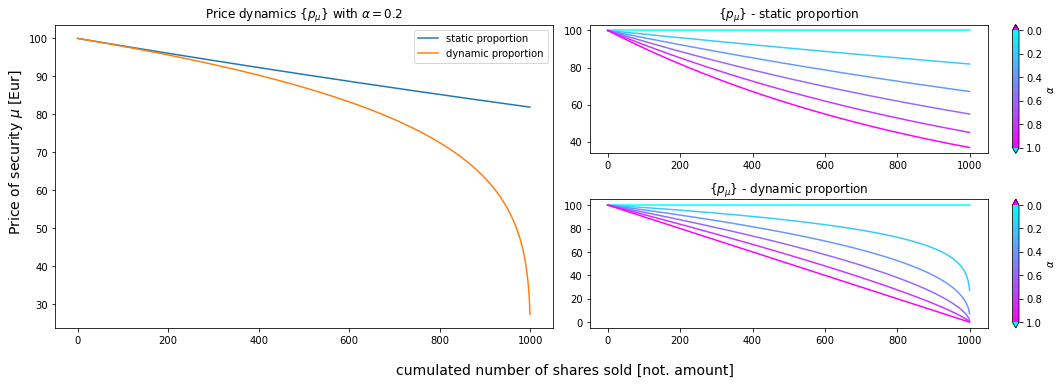

In [3]:
def main():
    price_dynamics = lambda v, alpha, delta:  v*np.exp(-alpha*delta)


    fig = plt.figure(figsize=(15,5) )
    v0, alpha, numerator = 100, 0.2, 1

    # Price dynamics where denominator of \delta stays constant 
    denominator = 1000
    max_iter = int(denominator / numerator )
    v, v[0] = np.empty(max_iter), v0
    for i in range(max_iter-1): 
        v[i+1] = price_dynamics(v[i], alpha, numerator/denominator)

    ax1 = plt.subplot(121)
    ax1.plot([i*numerator for i in range(len(v))], v, 
    label = "static proportion")


    # Price dynamics where proportion of sold amounts is relative 
    # to the total amounts available since the _previous_ period
    denominator, denominator[0] = np.empty(max_iter), 1000
    v, v[0] = np.empty(max_iter), v0
    for i in range(max_iter-1): 
        v[i+1] = price_dynamics(v[i], alpha, numerator/denominator[i])
        denominator[i+1] = denominator[i] - numerator

    ax1.plot([i*numerator for i in range(len(v))], v, 
    label = "dynamic proportion")

    ax1.set_title(fr"Price dynamics $\{{p_{{\mu}}\}}$ with $\alpha={alpha}$")
    ax1.legend();


    # Static proportion for different alpha values
    steps = 6
    alpha = np.linspace(0,1,steps)
    denominator = 1000
    max_iter = int(denominator / numerator )
    ax2 = plt.subplot(222)
    norm = matplotlib.colors.Normalize(
        vmin=np.min(alpha),
        vmax=np.max(alpha))
    s_m = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.cool, norm= norm)
    for each_alpha in alpha:
        v, v[0] = np.empty(max_iter), v0
        for i in range(max_iter-1): 
            v[i+1] = price_dynamics(v[i], each_alpha, numerator/denominator)
        ax2.plot([i*numerator for i in range(len(v))], v, 
        label = rf"$\alpha = {each_alpha}$", color=s_m.to_rgba(each_alpha))
    cb = plt.colorbar(s_m, ax= ax2, extend='both', label = r"$\alpha$")
    cb.ax.invert_yaxis()
    ax2.set_title(r"$\{p_{\mu}\}$ - static proportion")


    # dynamic proportion for different alpha values
    alpha = np.linspace(0,1,steps)
    denominator, denominator[0] = np.empty(max_iter), 1000
    ax3 = plt.subplot(224)
    norm = matplotlib.colors.Normalize(
        vmin=np.min(alpha),
        vmax=np.max(alpha))
    s_m = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.cool, norm= norm)
    for each_alpha in alpha:
        v, v[0] = np.empty(max_iter), v0
        for i in range(max_iter-1): 
            v[i+1] = price_dynamics(v[i], each_alpha, numerator/denominator[i])
            denominator[i+1] = denominator[i] - numerator
        ax3.plot([i*numerator for i in range(len(v))], v, 
        label = rf"$\alpha = {each_alpha}$", color=s_m.to_rgba(each_alpha))
    cb = plt.colorbar(s_m, ax= ax3, extend='both', label = r"$\alpha$")
    cb.ax.invert_yaxis()
    ax3.set_title(r"$\{p_{\mu}\}$ - dynamic proportion")
    
    fig.text(0.35, -0.05, "cumulated number of shares sold [not. amount]", fontsize= 14)
    fig.text(-0.01, 0.35, "Price of security $\mu$ [Eur]", fontsize= 14, rotation='vertical')
    plt.tight_layout()
main()

## Bank constraints

Next, we need to define the propagation logic of the model. We assume that a node can be characterized by a state variable $\phi$ as follows: 



$$
\phi_{i}^t =
    \begin{cases}
      1 & \text{if $node_i$ is in default at the end of time $t$}\\
      0 & \text{otherwise}
    \end{cases}      

$$

We further assume nodes will take the neccessary measures possible to avoid going into default.

There are two main channels that impact the state of a node. The first channel is determined by the capital of the node. A node goes into a default state if by the end of time $t$ we observe:

$$
CR_i = \frac{A_i - L_i}{w^b(l^l + l^s) + \sum_{\mu=1}^M w^{\mu}s_{\mu}^ip_{\mu} + C^{te}} < \bar{CR}
$$

with $\bar{CR}$ a regulatory lowerbound set for the risk-weighted capital ratio that banks need to adhere. Note that in denominator we subsume all of the risk-weighted assets that are not explictely part of the model within the constant $C^{te}$. 


The second channel that might impact the state of a node is determined by the liquidity position of the node. A node goes into into a default state if by the end of time $t$ we observe:

$$
c_i < \beta(d_i + b_i)
$$

with $\beta$ a liquidity buffer scaler.

We further assume that a timeperiod coincides with the maturity of short-term debt, that is during the shock propagation banks need to decide how much of their short-term debt to roll-over to their current debtors. In case a bank decides to withdraw its short-term funds from the market, its debtors might be facing dificulities in actually repaying the debt. This gives rise to an additional liquidity channel that impacts the state of a bank by the end of the time period. This is encoded as:

$$
p_i < f_i
$$

with $f_i$ the amount that $i$ needs to pay back from its total short-term interbank borrowings, and $p_i$ the $i$-th element of the clearing vector that clears the short-term interbank market at a certain timeperiod. Note the equivalence with an Eisenberg and Noe (2001) system when we set $f_i = \bar{p}_i$.


If any of the above is observed at the end of the timeperiod a node goes into a default state; 

$$
\phi_{i}^t =
    \begin{cases}
      1 & \text{if } CR_i < \bar{CR} \text{ or } c_i < \beta(d_i + b_i)  \text{ or } p_i < f_i \\
      0 & \text{otherwise}
    \end{cases}      

$$



## Modelling requirements

- The nodes $N$ balance sheet can be represented as `Pandas DataFrame` where each row depict a node and columns depict the different balance sheet items

- The Layers $\bm{W}$ can be represented as `Numpy ndarrays` based adjacency matrices. For the __external securities market__ we have a bipartite adjacency $W^3 \in R^{N \times M}$ matrix where rows depict the nodes of the system and columns depict securities. Entries in the matrix represent the notional amounts that the nodes are holding of a security $m \in M$. 

- We also need a vector $v \in R^M$ depicting the prices of the different securities

- As well as a vector $w \in R^M$ depicting the risk weights of the different securities

- We need to make sure that the set of nodes $N$ is consistent across the different data structures

All of this information can easily be requested/embedded within the `MultilayerNetwork` class available within the codebase of the DC-AAP project, but can also be created manually (especially with the use of `NetworkX`). 

In [909]:
# ## With the MultilayerNetwork class 
# from utils.parser import Parser
# parser = Parser(lab_nabe = "lab_prj_sds")
# parser.read_nodes(tbl_name_nodes)
# parser.read_layers(tbl_name_edges)
# G = parser.get_multiplex(layers = "all" # returns MultilayerNetwork object)

## Manually with dummy data
# ---------------------------------
# balance sheet info
df_nodes = pd.DataFrame(
    {"riad_cd": list("ABC"), 
    "cash": [1, 2, 3],
    "deposits": [1, 2, 3],
    }
)
# layers: N=3 M=2

# LT market: Bank B has a large exposure towards bank A
W_lt = np.array([ [0,0,0], [10, 0, 0], [1, 0, 0] ])
# ST market: Bank C has a large withdrawal risk coming from Bank B
W_st = np.array([ [0, 2, 0], [0, 0, 6], [0, 0, 0] ])
# Securities market: Bank C has a large portfolio to sell to avoid going in default
W_sec = np.array([ [5, 5], [2,0], [10, 10]]) 

v = np.array([1,2])
w = np.array([1, 1])

df_nodes["long_term_loans"] = W_lt @ np.ones(3)
df_nodes["short_term_loans"] = W_st @ np.ones(3)
df_nodes["long_term_borrowings"] = W_lt.T @ np.ones(3)
df_nodes["short_term_borrowings"] = W_st.T @ np.ones(3)

alpha = np.ones(2)*0.2
df_nodes["securities_portfolio"] = np.dot(W_sec, v)

df_nodes["total_assets"] = (df_nodes.cash + 
df_nodes.long_term_loans + 
df_nodes.short_term_loans + 
df_nodes.securities_portfolio + 
                           10)

df_nodes["total_liabilities"] = (df_nodes.deposits + 
df_nodes.long_term_borrowings + 
df_nodes.short_term_borrowings +
                                 10)


df_nodes["capital"] = df_nodes.total_assets - df_nodes.total_liabilities

df_nodes["risk_weighted_assets"] = df_nodes.capital / (0.2*(df_nodes.long_term_loans + df_nodes.short_term_loans) + df_nodes.securities_portfolio + [10, 60, 30])

df_nodes.head()

,riad_cd,cash,deposits,long_term_loans,short_term_loans,long_term_borrowings,short_term_borrowings,securities_portfolio,total_assets,total_liabilities,capital,risk_weighted_assets
0,A,1,1,0.000,2.000,11.000,0.000,15,28.000,22.000,6.000,0.236
1,B,2,2,10.000,6.000,0.000,2.000,2,30.000,14.000,16.000,0.245
2,C,3,3,1.000,0.000,0.000,6.000,30,44.000,19.000,25.000,0.415


In [910]:
# Params 
ALPHA = 0.2
BETA = 0.05
WEIGHT_IB = 0.2
GAMMA_BAR = 0.1

# initialization of variables
p = np.ones((len(df_nodes), 1))
f = np.zeros((len(df_nodes),1))
risk_weighted_securities = np.dot(W_sec, v*w).reshape(-1)
rwa_cte = (df_nodes.capital / df_nodes.risk_weighted_assets) - WEIGHT_IB * (df_nodes.short_term_loans + df_nodes.long_term_loans) - risk_weighted_securities
rwa = df_nodes.capital / (WEIGHT_IB * (df_nodes.short_term_loans + df_nodes.long_term_loans) + risk_weighted_securities) + rwa_cte

# Constraint vectors 
violation_capital = np.asarray(rwa < GAMMA_BAR).reshape(-1,1)
violation_liquidity = np.asarray(df_nodes.cash < BETA*(df_nodes.short_term_borrowings + df_nodes.deposits)).reshape(-1,1)
violation_repayment = p < f

## Clearing the markets 

After a shock propagates through the different layers we clear the market as follows: 

1. After obtaining the clearing vector $p$ and the sell-off matrix $Z$, we update the bipartite adjacency matrix $W^3$ to reflect the sold securities by the nodes: 

$$
W^3 = W^3 - Z
$$

2. Next we update the short-term interbank debt market to reflect the repayments made by the nodes based on the roll-over decisions: 
$$
W^2 = W^2  - (\Pi \cdot p)^T
$$

3. Now we update the balance sheets of the nodes based on the sales of their securities and short-term repayments: 
$$
\begin{align*}
& c = c + Z\cdot v   \text{ (revenue of selling securities)}\\
& c = c + \Pi^T \cdot p - (\Pi  \odot p) \cdot \mathbf{1} \text{ (net revenue of short-term roll-overs)}\\
& l^s = l^s - \Pi^T \cdot p \text{ portion of short-term loans being rolled-over to next period}\\
& b^s = b^s -  (\Pi  \odot p) \cdot \mathbf{1} \text{ (portion of short-term debt being repayed)}\\
\end{align*}
$$

4. Based on the contraints imposed on the nodes, we retrieve the newly defaulted nodes based on the updated balance sheets: 

$$
\phi_{i}^t =
    \begin{cases}
      1 & \text{if } CR_i < \bar{CR} \text{ or } c_i < \beta(d_i + b_i)  \text{ or } p_i < f_i \\
      0 & \text{otherwise}
    \end{cases}      
$$

5.  When a node $i$ goes into default its securities portfolio gets frozen by external authorities until the markets are stable again. This to avoid inducing further fire sales into the system. For our purposes this is equivalent to setting the securities portfolio of $i$ to $0$: 

$$
 \sum_{\mu=1}^M s_{\mu}^ip_{\mu} = 0
$$

6. We book the losses due to defaulted nodes within the short-term debt market: 

Afterwards we loop back through the different layers, starting from the long-term loan market. 

In [911]:
class ShockPropagator():
    # Params of model
    ALPHA = 0.2
    BETA = 0.05
    WEIGHT_IB = 0.2
    GAMMA_BAR = 0.1
    EPS = 10**-10 # machine epsilon approximation
    
    def __init__(self, df_nodes, W, v, weights_sec):

        self.df_nodes = df_nodes
        self.W_lt, self.W_st, self.W_sec = W
        self.v, self.weights_sec = v, weights_sec 
        self.n = self.W_sec.shape[0]
        self.m = self.W_sec.shape[1]

        # initialization of variables
        self.p = np.ones(self.n)
        self.f = np.zeros(self.n)
        
        self.risk_weighted_securities = W_sec @ (v*weights_sec)
        self.rwa_cte = ( (df_nodes.capital / df_nodes.risk_weighted_assets) - 
        WEIGHT_IB * (df_nodes.short_term_loans + df_nodes.long_term_loans) - risk_weighted_securities 
        )
        self.df_nodes["other_assets"] = self.df_nodes.total_assets - (self.df_nodes.cash + self.df_nodes.short_term_loans + self.df_nodes.long_term_loans + W_sec @ v )
        self.df_nodes["other_liabilities"] = self.df_nodes.total_liabilities - (self.df_nodes.deposits + self.df_nodes.short_term_borrowings + self.df_nodes.long_term_borrowings)
    
    def update_BS_totals(self):
        
        TA = self.df_nodes.cash + self.df_nodes.short_term_loans + self.df_nodes.long_term_loans + self.W_sec @ self.v + self.df_nodes.other_assets
        TL = self.df_nodes.deposits + self.df_nodes.short_term_borrowings + self.df_nodes.long_term_borrowings + self.df_nodes.other_liabilities
        self.df_nodes.total_assets = TA
        self.df_nodes.total_liabilities = TL
        self.df_nodes.capital = TA - TL
        
    
    def initial_shock(self, bank = int): 
        self.df_nodes.loc[bank, 'cash']= 0 
        self.df_nodes.loc[bank, 'other_liabilities'] = self.df_nodes.loc[bank, 'other_liabilities'] + self.df_nodes.loc[bank, 'capital']
        self.update_BS_totals()
        self.Z = np.zeros((self.n, self.m))
        self.PI = np.zeros((self.n, self.n))
        
        
    def get_defaults(self):
        
        # Compute current RWA level
        self.update_BS_totals()
        risk_weighted_securities = self.W_sec @ (self.v*self.weights_sec)
        self.rwa = (self.df_nodes.total_assets - self.df_nodes.total_liabilities) / (WEIGHT_IB * (self.df_nodes.short_term_loans + self.df_nodes.long_term_loans) + risk_weighted_securities + rwa_cte)
        
        # Update constraint vectors 
        self.violation_capital = np.asarray(self.rwa < GAMMA_BAR)
        self.violation_liquidity = np.asarray(df_nodes.cash < BETA*(df_nodes.short_term_borrowings + df_nodes.deposits))
        self.violation_repayment = self.p < self.f
        violations = [self.violation_capital, self.violation_liquidity, self.violation_repayment]
        return np.any(violations, axis= 0)

    def clear_market(self):

        # 1. Update holding matrix 
        self.W_sec = self.W_sec - self.Z
        # 2. Update short-term debt market 
        self.W_st = self.W_st - (self.PI*self.p).T
        # 3. Update BS items 
        self.df_nodes.cash += (self.Z @ self.v)
        self.df_nodes.cash += (self.PI.T @ self.p) - (self.PI * self.p) @ np.ones(self.n)
        self.df_nodes.short_term_loans -= (self.PI.T @ self.p)
        self.df_nodes.short_term_borrowings -= (self.PI * self.p) @ np.ones(self.n)
        
        self.df_nodes.cash = np.maximum(self.df_nodes.cash, 0)
        self.df_nodes.short_term_loans = np.maximum(self.df_nodes.short_term_loans, 0)
        self.df_nodes.short_term_borrowings = np.maximum(self.df_nodes.short_term_borrowings, 0)
        
        # 4. Get defaulted banks
        D = self.get_defaults()
        # 5. Freeze securities portfolio of defaulted banks 
        self.W_sec[D, : ] = 0 
        # 6. Book losses on short-term debt market 
        self.df_nodes.short_term_loans -= self.W_st[:, D] @ np.ones(D.sum())
        self.df_nodes.short_term_loans = np.maximum(self.df_nodes.short_term_loans, 0)
        self.W_st[:, D] = 0
        self.update_BS_totals()

In [912]:
sp = ShockPropagator(df_nodes.copy(), (W_lt, W_st, W_sec), v, w)
sp.df_nodes

,riad_cd,cash,deposits,long_term_loans,short_term_loans,long_term_borrowings,short_term_borrowings,securities_portfolio,total_assets,total_liabilities,capital,risk_weighted_assets,other_assets,other_liabilities
0,A,1,1,0.000,2.000,11.000,0.000,15,28.000,22.000,6.000,0.236,10.000,10.000
1,B,2,2,10.000,6.000,0.000,2.000,2,30.000,14.000,16.000,0.245,10.000,10.000
2,C,3,3,1.000,0.000,0.000,6.000,30,44.000,19.000,25.000,0.415,10.000,10.000


In [913]:
sp.initial_shock(bank = 0)
sp.df_nodes

,riad_cd,cash,deposits,long_term_loans,short_term_loans,long_term_borrowings,short_term_borrowings,securities_portfolio,total_assets,total_liabilities,capital,risk_weighted_assets,other_assets,other_liabilities
0,A,0,1,0.000,2.000,11.000,0.000,15,27.000,28.000,-1.000,0.236,10.000,16.000
1,B,2,2,10.000,6.000,0.000,2.000,2,30.000,14.000,16.000,0.245,10.000,10.000
2,C,3,3,1.000,0.000,0.000,6.000,30,44.000,19.000,25.000,0.415,10.000,10.000


In [914]:
sp.get_defaults()

array([ True, False, False])

In [915]:
sp.rwa

0   -0.039
1    0.245
2    0.415
dtype: float64

In [916]:
sp.get_defaults()

array([ True, False, False])

In [917]:
sp.clear_market()
sp.W_sec

array([[ 0.,  0.],
       [ 2.,  0.],
       [10., 10.]])

In [918]:
sp.get_defaults()

array([ True, False, False])

In [919]:
sp.df_nodes

,riad_cd,cash,deposits,long_term_loans,short_term_loans,long_term_borrowings,short_term_borrowings,securities_portfolio,total_assets,total_liabilities,capital,risk_weighted_assets,other_assets,other_liabilities
0,A,0.000,1,0.000,2.000,11.000,0.000,15,12.000,28.000,-16.000,0.236,10.000,16.000
1,B,2.000,2,10.000,6.000,0.000,2.000,2,30.000,14.000,16.000,0.245,10.000,10.000
2,C,3.000,3,1.000,0.000,0.000,6.000,30,44.000,19.000,25.000,0.415,10.000,10.000


## The long-term loan market 

At the beginning of each period, banks book losses from the long term interbank market, if any, due to the bankruptcy of their debtors in the previous period. These losses affect the capital of the bank and therefore can lead to the violation of their capital contraint. 

In [920]:
class ShockPropagator(ShockPropagator):

    def propagation_lt_loans(self):

        # Compute losses 
        D = self.get_defaults()
        L = self.W_lt[:, D] @ np.ones(D.sum())
        # Book losses
        self.df_nodes.long_term_loans -= L
        self.df_nodes.long_term_loans = np.maximum(self.df_nodes.long_term_loans, 0)
        self.W_lt[:, D] = 0
        self.update_BS_totals()

In [921]:
sp = ShockPropagator(df_nodes.copy(), (W_lt, W_st, W_sec), v, w)
sp.initial_shock(bank = 0)
sp.clear_market()
sp.propagation_lt_loans()

In [922]:
sp.get_defaults()

array([ True,  True, False])

In [923]:
sp.df_nodes

,riad_cd,cash,deposits,long_term_loans,short_term_loans,long_term_borrowings,short_term_borrowings,securities_portfolio,total_assets,total_liabilities,capital,risk_weighted_assets,other_assets,other_liabilities
0,A,0.000,1,0.000,2.000,11.000,0.000,15,12.000,28.000,-16.000,0.236,10.000,16.000
1,B,2.000,2,0.000,6.000,0.000,2.000,2,20.000,14.000,6.000,0.245,10.000,10.000
2,C,3.000,3,0.000,0.000,0.000,6.000,30,43.000,19.000,24.000,0.415,10.000,10.000


In [924]:
sp.rwa

0   -1.538
1    0.095
2    0.400
dtype: float64

In [607]:
def get_defaulted_nodes(E: np.ndarray):

    E = np.asarray(E)
    constraint: np.ndarray = E < 0

    return constraint

def book_losses(A: np.ndarray, E: np.ndarray, Dt: np.ndarray):

    L = A[:, Dt].sum(axis = 1)
    E = E - L 
    A[:, Dt] = 0

    return A, E

def pprint(dict_):
    for k,v in dict_.items():
        print(f"{k}:{v}")

In [608]:
def default_cascade(A: np.ndarray, E: np.ndarray, Dt: np.ndarray): 
    
    Dt = np.ma.make_mask(Dt)
    E[Dt] = -1
    i, in_equilibrium, defaulted_nodes, defaulted_nodes[0] = 0, False, {}, Dt
    while not in_equilibrium:

        A, E = book_losses(A, E, Dt)
        Dt_new = get_defaulted_nodes(E)
        
        defaulted_nodes[i+1] = Dt_new
        in_equilibrium = np.array_equal(Dt, Dt_new)
        Dt = Dt_new
        i+=1
    
    print(f"Default cascade stopped in {i} steps!")
    return A, E, defaulted_nodes

A, E, defaults = default_cascade(A= W1.copy(), E= df_nodes.capital, Dt= [1, 0, 0])
pprint(defaults)

NameError: name 'W1' is not defined

## The short-term loan market

If a node's constraint is violated, it will need to react adequately to avoid going into default. The first step to undertake is to reduce its short-term interbank market exposures. We __assume__ that __each period in the model coincides with the maturity level of short-term loans__, that is at the end of each period nodes need to decide on the amount of their short-term debt they want to __roll-over__ to their debtors for next period. 

This endogenous decision is based on two factors: 

(i) The need to make sure the nodes constraints are satisfied 

(ii) The fact that a nodes own funding from other creditors is being reduces, forcing it to withdraw more money from its debtors

This endogenous decision making can be formulated by the following mapping: 

$$
f \odot l^s = (r + (W_2^Tf - c_{buf} \vee 0)) \wedge l^s \quad (16)
$$

with 

- $c_{buf} = (c - \beta(d+b^s-W_2^Tf)) \vee 0 $ the cash above the liq buffer that can be used to pay back short-term creditors

and 
- $ x \wedge y := (min(x_1, y_1), ..., min(x_n, y_n)) $
- $ x \odot y := (x_1 \cdot x_2), ..., x_n \cdot x_2) $

element-wise operations, and

- $f \in R^N$ a vector denoting percentage of funds being withdrawn from the short-term market by the $N$ nodes
- $l^s \in R^N$  a vector denoting the total short-term exposures of the $N$ nodes
- $r \in R^N$ a vector denoting the amount of funds each bank wants to withdraw to satisfy their constraints

We can decompose $r$ in two additive components being: 

$$
\begin{align*}
&r^{liq} =  l^s \wedge ( \beta(d+b^s-W_2^T \cdot f) - c \vee 0 ) \\
&r^{cap} = (l^s - r^{liq}) \wedge ( \frac{\bar{CR}(C^{te} + W_3 \cdot (w\odot p) ) +  \bar{CR}w^b(l^l+l^s-r^{liq}) - (A- L)}{\bar{CR}w^b}   \vee 0)
\end{align*}
$$

with $r^{liq}$ taking care of liquidity requirements and $r^{cap}$ taking care of capital requirements. 

The above loop describes how a node withdraws funds from the short-term market only if it has problems fulfilling its constraints and in case other nodes decide to withdraw their funds that are deposited with the node. 

Note the __similarities between (16) and the mapping introduces by Eisenberg & Noe (2001) depicted in (9)__. We can leverage the same mathemetical tools as we have done before to solve (16). To do so we need to rewrite (16), noting that the mapping is homegenous of degree $1$, that is: 

$$
x_{t+1}K = mx_t + b \wedge K \\
\Leftrightarrow x_{t+1} = \frac{mx_t + b}{K} \wedge 1 
$$

we get, 

$$
f = \frac{r + (W_2^Tf - c_{buf} \vee 0)}{l_s} \wedge 1 \quad (17)
$$

Using (17) we can easily find the short-term equilibrium state of the short-term interbank market.

In [938]:
class ShockPropagator(ShockPropagator):       
    
    def f_map(self, f):
        
        r_liq = np.minimum(self.df_nodes.short_term_loans, np.maximum(self.BETA*(self.df_nodes.deposits + self.df_nodes.short_term_borrowings - self.W_st.T @ f), 0))
        r_cap_upper_bound = (self.df_nodes.short_term_loans - r_liq)
        r_cap_securities = self.GAMMA_BAR * ( self.rwa_cte + self.W_sec @ (self.weights_sec*self.v) )
        r_cap_loans = self.GAMMA_BAR*self.WEIGHT_IB * (self.df_nodes.long_term_loans + self.df_nodes.short_term_loans - r_liq) - self.df_nodes.capital
        r_cap = (r_cap_securities + r_cap_loans) / (self.GAMMA_BAR*self.WEIGHT_IB)
        r_cap = np.minimum(r_cap_upper_bound, np.maximum(r_cap, 0))        
        r = r_liq + r_cap
        c_buf = np.maximum(self.df_nodes.cash - self.BETA*(self.df_nodes.deposits + self.df_nodes.short_term_borrowings - self.W_st.T @ f ), 0)
        n = self.W_st.shape[1]
        l = self.W_st.sum(axis=1)
        f_loop = lambda f, W, l , r, c_buf: np.minimum( (r + np.maximum(W.T @ f - c_buf, 0) ) / (l + self.EPS),  1)
        self.r = r
        return f_loop(f, self.W_st, l , r, c_buf)
    
    def liquidity_cascades(self):
        n = self.W_st.shape[1]
        self.f = optimize.fixed_point(self.f_map, np.zeros(n))
    
    
    
    
def liquidity_cascades(A: np.ndarray, r: np.ndarray, c_buf: np.ndarray):

    n = A.shape[1]
    l = A.sum(axis=1)
    f_loop = lambda f, A, l , r, c_buf: np.minimum( (r + np.maximum(A.T @ f - c_buf, 0) ) / l,  1)
    f = optimize.fixed_point(f_loop, np.zeros(n), args=(A, l, r, c_buf))
    return f




In [941]:
sp = ShockPropagator(df_nodes.copy(), (W_lt, W_st, W_sec), v, w)
sp.initial_shock(bank = 0)
sp.clear_market()
sp.propagation_lt_loans()
sp.f_map(np.zeros(3))
sp.liquidity_cascades()

In [942]:
sp.f

array([1.        , 0.03333333, 0.        ])

## The securities market

Once banks decide about how much to withdraw from the interbank market, they may still need to sell securities in order to pay back eventual short-term creditors and/or to fulfil their constraints. 


In [975]:
class ShockPropagator(ShockPropagator):     
    
    def update_prices(self):
        total_security_available_vector = np.ones((1, self.n)) @ self.W_sec
        total_security_sold_vector = np.ones((1, self.n)) @ self.Z
        delta =  total_security_sold_vector / (total_security_available_vector + self.EPS)
        delta = delta.T.reshape(-1)
        self.v = self.v * np.exp(-self.ALPHA * delta)
    
    def p_map(self, p):
        
        # Init variables 
        PI = (self.W_st * self.f).T
        p_bar = self.W_st.T @ self.f
        pi = PI / (p_bar + self.EPS)
        mv = self.W_sec * self.v
        mv_total = mv @ np.ones(self.m)
        eta = mv / (mv_total + self.EPS).reshape(-1,1)
        self.update_prices()
        self.update_BS_totals()
        
        # Z component for interbank market 
        c_buf = np.maximum(self.df_nodes.cash - self.BETA*(self.df_nodes.deposits + self.df_nodes.short_term_borrowings - self.W_st.T @ self.f ), 0)
        liq_need = (p_bar - c_buf - pi.T @ p)
        liq_need = np.maximum(liq_need, 0).to_numpy()
        Z_ib =  np.minimum(self.W_sec, (liq_need[:, None] * eta) / self.v )
        
        # Z component for liquidity constraint
        liq_need = self.df_nodes.cash - self.BETA*(self.df_nodes.deposits + self.df_nodes.short_term_borrowings - self.W_st.T @ self.f)
        liq_need = np.maximum(liq_need, 0).to_numpy()
        Z_liq = np.minimum(self.W_sec - Z_ib, (liq_need[:, None] * eta) / self.v)
        
        # Z component for capital constraint
        loans = self.df_nodes.long_term_loans + self.df_nodes.short_term_loans - self.r
        W_sec_new = self.W_sec - Z_ib - Z_liq
        liq_need = self.WEIGHT_IB * loans + self.rwa_cte + W_sec_new @ (self.weights_sec * self.v) - (self.df_nodes.capital / self.GAMMA_BAR)
        liq_need = np.maximum(liq_need, 0).to_numpy()
        Z_cap = np.minimum(W_sec_new, (liq_need[:, None] * eta) / self.v.T )
        
        self.Z = Z_ib + Z_liq + Z_cap
        
        p_loop = lambda p, pi, p_bar, c, Z, v: np.minimum(pi.T @ p + c + Z @ v, p_bar)
        return p_loop(p, pi, p_bar, self.df_nodes.cash, self.Z, self.v)
        
    
    def fire_sales(self):
        n = self.W_sec.shape[0]
        self.p = optimize.fixed_point(self.p_map, np.zeros(n))


In [976]:
sp = ShockPropagator(df_nodes.copy(), (W_lt, W_st, W_sec), v, w)
sp.initial_shock(bank = 0)
sp.clear_market()
sp.propagation_lt_loans()
sp.liquidity_cascades()
sp.fire_sales()

In [977]:
sp.p

array([0. , 2. , 0.2])

In [978]:
sp.v

array([0.86547846, 1.89814486])

In [980]:
sp.rwa

0   -1.538
1    0.242
2    0.391
dtype: float64

In [951]:
sp.rwa

0   -1.538
1    0.245
2    0.415
dtype: float64